In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
import dill
import re
from razdel import tokenize
import pymorphy2
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import roc_auc_score
#from pymystem3 import Mystem
nltk.download('stopwords')
stopword_ru = stopwords.words('russian')
df = pd.read_csv('labeled.csv')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mahhets\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
df.head(3)

,comment,toxic
0,"Верблюдов-то за что? Дебилы, бл...\n",1.0
1,"Хохлы, это отдушина затюканого россиянина, мол...",1.0
2,Собаке - собачья смерть\n,1.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14412 entries, 0 to 14411
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   comment  14412 non-null  object 
 1   toxic    14412 non-null  float64
dtypes: float64(1), object(1)
memory usage: 225.3+ KB


In [4]:
df.describe()

,toxic
count,14412.000000
mean,0.334860
std,0.471958
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


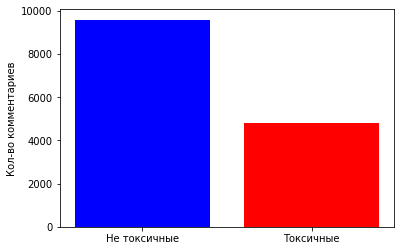

In [5]:
gdf = df.groupby('toxic').describe()
plt.bar('Не токсичные',gdf['comment']['count'][0], label = 'Не токсичные', color = 'blue')
plt.bar('Токсичные',gdf['comment']['count'][1], label = 'Токсичные', color = 'red')
plt.ylabel('Кол-во комментариев')
plt.show()

In [6]:
# Допустим, что данных стоп-слов не достаточно, тогда можно добавить свои стоп-слова
with open('stopwords.txt') as f:
    adittional_stopwords = [w.strip() for w in f.readlines()if w]
stopword_ru += adittional_stopwords

### Напишем класс для выбора атрибута

In [7]:
class FeatureSelector(BaseEstimator, TransformerMixin):
    """
    Отвечает за выбор признака. В конкретном решении можно обойтись без него
    """
    
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[[self.column]]

### Напишем классы для очистки текста

1. Стандартная очистка текста от сложноинтепретируемых значений

In [8]:
class Cleaner(BaseEstimator, TransformerMixin):
    def __init__(self,column):
        self.column = column
        
    @staticmethod
    def clean_text(text):
        if not isinstance(text, str):
            text = str(text)
        
        text = text.lower() # делаем все буквы маленькими
        text = text.strip('\n').strip('\r').strip('\t') # удаляет начальные и конечные символы в строке
        text = re.sub("-",' ',str(text))
        text = re.sub("-\s\r\n\|-\s\r\n|\r\n", '', str(text)) # re.sub ищет шаблон в подстроке и заменяет его на строку
        text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
        text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text)
        text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())
        text = re.sub("\n", ' ', text)
        stopword_ru = stopwords.words('russian')
        tokens = list(tokenize(text))
        words = [_.text for _ in tokens]
        words = [w for w in words if w not in stopword_ru]
    
        return " ".join(words)
    
    def fit(self, X, y= None):
        return self
    
    def transform(self, X, y = None):
        X[self.column] = X[self.column].apply(lambda x: self.clean_text(x),1)
        return X[[self.column]]

2. Для нормализации слов мною был сделан выбор в пользу **лемматизации**.
В отличии от **стемминга**(грубая форма, попытается отбросить суффиксы и т.д.), лемматизация превращает различные формы слов в меньшее кол-во вариантов этих слов с **минимум потери смысловой нагрузки**.

In [9]:
class Lemma(BaseEstimator, TransformerMixin):

    def __init__(self, column):
        self.column = column
        self.cache = {}
        self.morph = pymorphy2.MorphAnalyzer()
        self.stopword_ru = stopwords.words('russian')
    
    def lemmatization(self,text):

        if not isinstance(text, str):
            text = str(text)
    
        tokens = list(tokenize(text))
        words = [_.text for _ in tokens]

        words_lem = []
        for w in words:
            if w[0] == '-': 
                w = w[1:]
            if len(w)>1: 
                if w in self.cache: 
                    words_lem.append(self.cache[w])
                else: 
                    temp_cach = self.cache[w] = self.morph.parse(w)[0].normal_form
                    words_lem.append(temp_cach)
    
        words_lem_without_stopwords=[i for i in words_lem if not i in self.stopword_ru] 
    
        return ' '.join(list(words_lem_without_stopwords))
    
    def fit(self, X, y = None):
        return self
    
    def transform(self, X, y = None):
        X[self.column] = X[self.column].apply(lambda x: self.lemmatization(x),1)
        return X[self.column].values.astype('U')

### Создадим пайплайны для 4 классификаторов:
- MultinomialNB
- RandomForestClassifier
- LogisticRegression
- SGDClassifier

In [10]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier

In [11]:
classifier_1 = Pipeline([('selector', FeatureSelector(column='comment')),
                         ('cleaner', Cleaner(column='comment')),
                         ('lemma', Lemma(column='comment')),
                         ('tfidf', TfidfVectorizer(sublinear_tf=True,
                                                            strip_accents='unicode',
                                                            analyzer='word', # аналитика по словам
                                                            token_pattern=r'\w{1,}', # выдергиваем разделители
                                                # длина ngram(ngram - смотрим на последовательности слов длиной 1 с шагом 1)
                                                            ngram_range=(1, 1), 
                                                            max_features=10000)),
                         ('clf', MultinomialNB())])

classifier_2 = Pipeline([('selector', FeatureSelector(column='comment')),
                         ('cleaner', Cleaner(column='comment')),
                         ('lemma', Lemma(column='comment')),
                         ('tfidf', TfidfVectorizer(sublinear_tf=True,
                                                            strip_accents='unicode',
                                                            analyzer='word', 
                                                            token_pattern=r'\w{1,}', 
                                                            ngram_range=(1, 1), 
                                                            max_features=10000)), 
                         ('clf', SGDClassifier(loss='modified_huber', penalty='l2', alpha=1e-3))])


classifier_3 = Pipeline([('selector', FeatureSelector(column='comment')),
                         ('cleaner', Cleaner(column='comment')),
                         ('lemma', Lemma(column='comment')),
                         ('tfidf', TfidfVectorizer(sublinear_tf=True,
                                                            strip_accents='unicode',
                                                            analyzer='word', 
                                                            token_pattern=r'\w{1,}', 
                                                            ngram_range=(1, 1), 
                                                            max_features=10000)), 
                         ('clf', LogisticRegression(penalty='l2',C=2))])

classifier_4 = Pipeline([('selector', FeatureSelector(column='comment')),
                         ('cleaner', Cleaner(column='comment')),
                         ('lemma', Lemma(column='comment')),
                         ('tfidf', TfidfVectorizer(sublinear_tf=True,
                                                            strip_accents='unicode',
                                                            analyzer='word', 
                                                            token_pattern=r'\w{1,}', 
                                                            ngram_range=(1, 1), 
                                                            max_features=10000)), 
                         ('clf', RandomForestClassifier())])

### Разбиение данных и кросс-валидация

In [12]:
# Разбиение данных
X_train, X_test, y_train, y_test = train_test_split(df.drop('toxic', 1), 
                                                    df['toxic'], random_state=42)

#save test
X_test.to_csv("X_test.csv", index=None)
y_test.to_csv("y_test.csv", index=None)
#save train
X_train.to_csv("X_train.csv", index=None)
y_train.to_csv("y_train.csv", index=None)

Сделаем кросс-валидацию каждого классификатора на 6 фолдах, в кач-ве скоринга используем ROC_AUC

In [13]:
%%time
#запустим кросс-валидацию классификаторов
cv_scores_1 = cross_val_score(classifier_1, X_train, y_train, cv=6, scoring='roc_auc') 
cv_score_1 = np.mean(cv_scores_1)
print('MultinomialNB CV score is {}'.format(cv_score_1))

cv_scores_2 = cross_val_score(classifier_2, X_train, y_train, cv=6, scoring='roc_auc') 
cv_score_2 = np.mean(cv_scores_2)
print('SGDClassifier CV score is {}'.format(cv_score_2))

cv_scores_3 = cross_val_score(classifier_3, X_train, y_train, cv=6, scoring='roc_auc') 
cv_score_3 = np.mean(cv_scores_3)
print('LogisticRegression CV score is {}'.format(cv_score_3))

cv_scores_4 = cross_val_score(classifier_4, X_train, y_train, cv=6, scoring='roc_auc') 
cv_score_4 = np.mean(cv_scores_4)
print('RandomForestClassifier CV score is {}'.format(cv_score_4))

<ipython-input-8-7a93630c41af>:14: FutureWarning: Possible nested set at position 39
  text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)


MultinomialNB CV score is 0.9408880757749553
SGDClassifier CV score is 0.9320180785648553
LogisticRegression CV score is 0.930997997894199
RandomForestClassifier CV score is 0.890529311583089
Wall time: 6min 33s


Обучим классификаторы и для каждого получим скор

In [14]:
%%time

classifier_1.fit(X_train, y_train)
y_score_1 = classifier_1.predict_proba(X_test)[:, 1]

classifier_2.fit(X_train, y_train)
y_score_2 = classifier_2.predict_proba(X_test)[:, 1]

classifier_3.fit(X_train, y_train)
y_score_3 = classifier_3.predict_proba(X_test)[:, 1]

classifier_4.fit(X_train, y_train)
y_score_4 = classifier_4.predict_proba(X_test)[:, 1]

Wall time: 1min 22s


In [15]:
from sklearn.metrics import precision_recall_curve

precision_1, recall_1, threshold_1 = precision_recall_curve(y_test.values, y_score_1)
precision_2, recall_2, threshold_2 = precision_recall_curve(y_test.values, y_score_2)
precision_3, recall_3, threshold_3 = precision_recall_curve(y_test.values, y_score_3)
precision_4, recall_4, threshold_4 = precision_recall_curve(y_test.values, y_score_4)


#Найдем F-меру для каждого классификатора
f_score_1 = (2*precision_1 * recall_1)/(precision_1 + recall_1)
f_score_2 = (2*precision_2 * recall_2)/(precision_2 + recall_2)
f_score_3 = (2*precision_3 * recall_3)/(precision_3 + recall_3)
f_score_4 = (2*precision_4 * recall_4)/(precision_4 + recall_4)

# найдем индекс максимального значения F-меры. При этом эти же индексы будут принадлежать оптимальным значениям 
# точности, полноты и порога
ix1 = np.argmax(f_score_1)
ix2 = np.argmax(f_score_2)
ix3 = np.argmax(f_score_3)
ix4 = np.argmax(f_score_4)

roc_score_1 = roc_auc_score(y_test, y_score_1)
roc_score_2 = roc_auc_score(y_test, y_score_2)
roc_score_3 = roc_auc_score(y_test, y_score_3)
roc_score_4 = roc_auc_score(y_test, y_score_4)

In [16]:
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, confusion_matrix

precision, recall, thresholds = precision_recall_curve(y_test.values, y_score_1)
fscore = (2 * precision_1 * recall_1) / (precision_1 + recall_1)
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix1], 
                                                                        fscore[ix1],
                                                                        precision[ix1],
                                                                        recall[ix1]))
print(roc_auc_score(y_test.values,y_score_1))

Best Threshold=0.337659, F-Score=0.832, Precision=0.841, Recall=0.823
0.9433408435230438


In [17]:
pd.DataFrame(data = [[f_score_1[ix1],roc_score_1,precision_1[ix1],recall_1[ix1],threshold_1[ix1]],
                    [f_score_2[ix2],roc_score_2, precision_2[ix2],recall_2[ix2],threshold_2[ix2]],
                    [f_score_3[ix3],roc_score_3,precision_3[ix3],recall_3[ix3],threshold_3[ix3]],
                    [f_score_4[ix4],roc_score_4,precision_4[ix4],recall_4[ix4],threshold_4[ix4]]], 
            index = ['MultinomialNB','SGDClassifier','LogReg','RFC'],
            columns = ['F_score','ROC-AUC','Precision','Recall','Threshold'])

,F_score,ROC-AUC,Precision,Recall,Threshold
MultinomialNB,0.832098,0.943341,0.841270,0.823123,0.337659
SGDClassifier,0.820059,0.931867,0.801483,0.839517,0.389983
LogReg,0.818220,0.931465,0.800330,0.836928,0.371456
RFC,0.750205,0.895134,0.716078,0.787748,0.380000


**Остановимся на наивном Байесовском классификаторе. Модель проста и в нашем случае оказалась довольно полезна**

Посмотрим на AUC_ROC

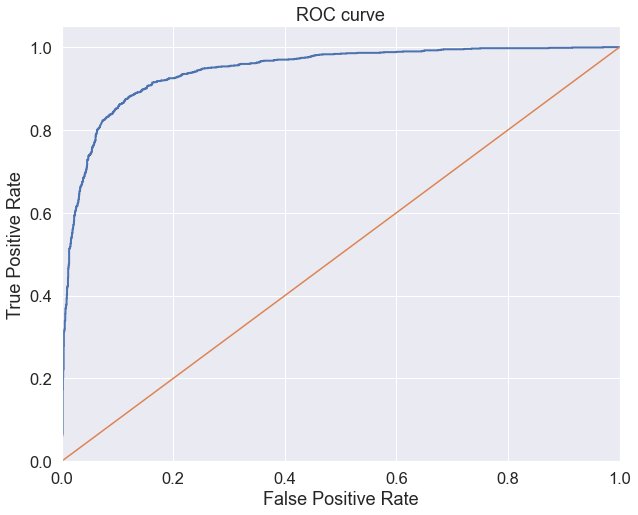

In [18]:
import seaborn as sns
import itertools
import matplotlib.pyplot as plt


%matplotlib inline
sns.set(font_scale=1.5)
sns.set_color_codes("muted")


plt.figure(figsize=(10, 8))
fpr, tpr, thresholds_ = roc_curve(y_test, y_score_1, pos_label=1)
lw = 2
plt.plot(fpr, tpr, lw=lw, label='ROC curve ')
plt.plot([0, 1], [0, 1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.savefig("ROC.png")
plt.show()

In [19]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Normalized confusion matrix
[[0.92635025 0.07364975]
 [0.17773943 0.82226057]]


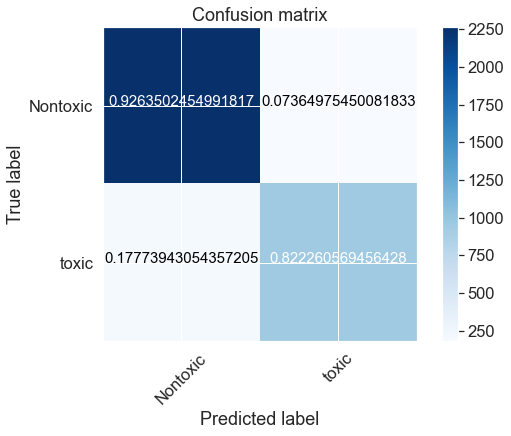

In [20]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, y_score_1>thresholds[ix1])
plt.figure(figsize=(8, 6))
plot_confusion_matrix(cnf_matrix, classes=['Nontoxic', 'toxic'], normalize=True,
                      title='Confusion matrix')
plt.show()

In [21]:
TN = cnf_matrix[0][0]
FN = cnf_matrix[1][0]
TP = cnf_matrix[1][1]
FP = cnf_matrix[0][1]

In [22]:
TPR = TP/(TP+FN)
FPR = FP/(FP+TN)
TNR = TN/(FP+TN)
TPR, FPR, TNR

(0.822260569456428, 0.07364975450081833, 0.9263502454991817)

- Мы может автоматически отсеивать ≈ 83% токсичных комментариев, что значительно облегчает жизнь тем же модераторам
- Всего 7,5% не токсичных комментариев получают метку 'токсичный'

**Как и говорил ранее, создадим полный пайплайн для лучшей модели и обучим ее на всех данных**

In [24]:
classifier = Pipeline([('selector', FeatureSelector(column='comment')),
                         ('cleaner', Cleaner(column='comment')),
                         ('lemma', Lemma(column='comment')),
                         ('tfidf', TfidfVectorizer(sublinear_tf=True,
                                                            strip_accents='unicode',
                                                            analyzer='word', # аналитика по словам
                                                            token_pattern=r'\w{1,}', # выдергиваем разделители
                                                # длина ngram(ngram - смотрим на последовательности слов длиной 1 с шагом 1)
                                                            ngram_range=(1, 1), 
                                                            max_features=10000)),
                         ('clf', MultinomialNB())])

In [27]:
X_train

,comment
5049,Козырёк на второй фотке дешёвым сайдингом обши...
4192,"Переключение между полями ввода, кнопками и пр..."
10605,1. Ни один метод не даёт гарантию 100 по этому...
9185,"А я б хотел каждый день пить, но проклятый ток..."
9970,"это для ножного управления, подходят современн..."
...,...
5191,Ну не знаю. А откуда тогда машин столько у люд...
13418,А у меня кандидатка завалилась на электрохроми...
5390,Второй сезон полная хуета!\n
860,"Мда... Хотел просто спасибо сказать, но и тут ..."


In [32]:
%%time
classifier.fit(df[['comment']],df[['toxic']])

Wall time: 10.6 s


c:\python3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Pipeline(steps=[('selector', FeatureSelector(column='comment')),
                ('cleaner', Cleaner(column='comment')),
                ('lemma', Lemma(column='comment')),
                ('tfidf',
                 TfidfVectorizer(max_features=10000, strip_accents='unicode',
                                 sublinear_tf=True, token_pattern='\\w{1,}')),
                ('clf', MultinomialNB())])

In [33]:
with open("NB_pipeline.dill", "wb") as f:
    dill.dump(classifier, f)